In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

# Jonathan Scott

# Resources
https://rachellegardner.com/isbn-10-isbn-13-and-those-pesky-x%E2%80%99s/

https://sellercentral.amazon.com/forums/thread.jspa?threadID=17640

https://stackoverflow.com/questions/7881994/matplotlib-how-to-change-data-points-color-based-on-some-variable

https://matplotlib.org/examples/mplot3d/scatter3d_demo.html

# Background

The task was using a Lab-41 dataset create a simple recommender system. Before I started the challenge  I knew nothing about machine learning let alone deep learning. In an attempt to fix this I took a Udemy course on deep learning. In the course the instructor used a Stacked AutoEncoder to make a simple recommender system. I thought I could try to do the same thing. I had problems getting the model to perform to my liking as I was experiecing overfitting. I discuss this later on.

### Importing the dataset
I am using a MacBook Pro (Retina, 13-inch, Early 2015) with 8 GB 1867 MHz DDR3 of RAM. 
I also used the scientific IDE Spyder before transferring my work into this jupyter notebook, which when idle uses around 76% of my memory. This means that I do not have much space left for using the entire bx-data set. 

In [2]:
#books = pd.read_csv('BX-CSV-Dump/BX-Books.csv', sep = ';', header = None,engine= 'python',encoding = 'latin-1',error_bad_lines=False)
#users = pd.read_csv('BX-CSV-Dump/BX-Users.csv', sep = ';', header = None,engine= 'python',encoding = 'latin-1',error_bad_lines=False)
n = 1149767 #number of records in file
s = 10000 #desired sample size
skip = sorted(random.sample(xrange(n),n-s))
#ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', sep = ';', header = None,engine= 'python',encoding = 'latin-1',error_bad_lines=False,skiprows=skip)
ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', sep = ';', header = None,engine= 'python',encoding = 'latin-1',error_bad_lines=False,skiprows=1)

Skipping line 21689: ';' expected after '"'
Skipping line 45329: ';' expected after '"'
Skipping line 45330: ';' expected after '"'
Skipping line 183262: ';' expected after '"'
Skipping line 210093: ';' expected after '"'
Skipping line 531938: ';' expected after '"'
Skipping line 663237: ';' expected after '"'
Skipping line 824822: ';' expected after '"'
Skipping line 877349: ';' expected after '"'
Skipping line 941679: ';' expected after '"'
Skipping line 1134132: ';' expected after '"'
Skipping line 1145176: ';' expected after '"'
Skipping line 1145177: ';' expected after '"'
Skipping line 1148551: ';' expected after '"'


In [3]:
ratings_sampled = ratings.sample(n=10000) # This is used to get a sample of the data with a distribution 
#that reflects the original data
#ratings.head()

In [4]:
ratings_sampled.head()

,0,1,2
858732,207669,0552998486,9
252840,57974,000649840X,5
462810,110973,0373026099,0
136002,30985,0684834731,9
352614,84831,3499108518,0


### Data Inspection and Visualzation

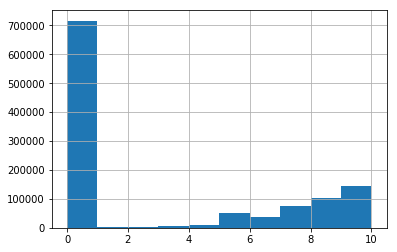

In [69]:
#Looking at the distribution of ratings
ratings[2].hist(bins=10)

**Below I am checking to see how my sample compares to the original distribution.
It seems to be a good representation of the whole data.**

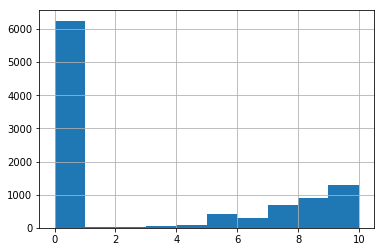

In [70]:
# fig = plt.figure(figsize=(11,8))
# ax = fig.add_subplot(111) 
# ax.hist(np.array(ratings[2]),bins=10)
# ax.hist(np.array(ratings_sampled[2]),bins=10)
ratings_sampled[2].hist(bins=10)


We are focused on the ratings data. The first column is a user-id, the second column is a ISBN number for a book and the third column is a book rating given by a user. After inspecting more of the ISBN number column, I noticed that not all entries are integers, some had X's in them. Which would make it hard to input into a neural network so I decided to map the userIDs and the ISBN numbers to smaller integers in order to have in a format that the PyTorch module can work with.

#### Mapping of userIds and ISBN columns

In [7]:
#remap USER IDs, so it is easy to get nb_users
id_users = ratings_sampled[0].unique()
user_map = {}
user_count = 0
for user in id_users:
    user_map[user] = user_count
    user_count+=1

In [8]:
id_books = ratings_sampled[1].unique()
books_map = {}
book_count = 0
for book in id_books:
    books_map[book] = book_count
    book_count+=1

In [10]:
ratings_user_mapped = ratings_sampled[0].map(user_map)
ratings_book_mapped = ratings_sampled[1].map(books_map)
pieces = [ratings_user_mapped, ratings_book_mapped ,ratings_sampled[2]]
mapped_ratings = pd.concat(pieces,axis=1)

In [11]:
mapped_ratings.head(5)

,0,1,2
858732,0,0,9
252840,1,1,5
462810,2,2,0
136002,3,3,9
352614,4,4,0


Now with these mapped ratings, it is easier to visualize the data based on book ratings.
But there are way to many points to see any helpful relationships. Doing this 3D plot did not help me at all. I was just trying out different visualizations. 

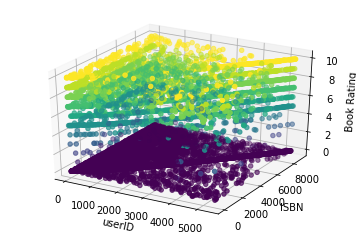

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mapped_ratings[0], mapped_ratings[1], mapped_ratings[2],c=mapped_ratings[2])
ax.set_xlabel('userID')
ax.set_ylabel('ISBN')
ax.set_zlabel('Book Rating')
plt.show()

## Training and Test set data split


In [12]:
training_set, test_set = train_test_split(mapped_ratings,test_size=0.20)
training_set = np.array(training_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [18]:
# Getting the number of users and books
nb_users = int(max(max(training_set[:,0]),max(test_set[:,0])))
nb_books = int(max(max(training_set[:,1]),max(test_set[:,1])))
training_set[:,1]#[mapped_ratings[:,0] == 1]
#nb_books

array([2003, 2932, 6225, ..., 7822, 7210, 4484])

In [19]:
# Converting the data into an array with users in lines and books in columns
def convert(data): #check
    new_data = []
    for id_user in range(0, nb_users):
        id_book = data[:,1][data[:,0] == id_user]
        id_ratings = data[:,2][data[:,0] == id_user]
        ratings = np.zeros(nb_books)
        ratings[id_book] = id_ratings #numpy matches things up.
        new_data.append(list(ratings))
    return new_data

In [20]:
training_set = convert(training_set)

In [21]:
test_set = convert(test_set)

In [22]:
# Converting the data into Torch tensors
# tensors are mutlidimensional arrays that contain elements of a single data type.
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

# Creating the architecture of the Neural Network

In [23]:
class SAE(nn.Module):
    def __init__(self):
        super(SAE,self).__init__()
        self.fc1 = nn.Linear(nb_books, 20)#with 20 we trying to detect 20 features
        self.fc2 = nn.Linear(20, 10)
        #self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(10, 20 )#reconstructing matches first encode
        #self.dropout_2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(20, nb_books )#reconstructed features
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        #x = self.dropout(x)
        x = self.activation(self.fc3(x))
        #x = self.dropout_2(x)
        x = self.fc4(x) #vector of predicted ratings
        return x

In [24]:
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5) # decay decrease learning rate every few epochs

### Testing the SAE

In [34]:
def TestSAE():
    test_loss = 0
    s = 0.
    output_numpy_all = np.empty([0,nb_books])
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)#pytorch needs this dummy dimension
        target = Variable(test_set[id_user])
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False # don't compare against target
            output[target == 0] = 0
            output_numpy = output.data.numpy()
            output_numpy_all = np.vstack((output_numpy_all, output_numpy) )
            loss = criterion(output,target)
            mean_corrector = nb_books/float(torch.sum(target.data > 0) + 1e-10)
            test_loss += np.sqrt(loss.data[0]*mean_corrector) #this has the loss in the loss object
            s += 1.
    print('Test loss is: '+str(test_loss/s))
    return test_loss/s

### Training the SAE

In [37]:
tr_losses = []
test_losses = []
nb_epoch = 150 #100,200
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)#pytorch needs this dummy dimension
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False # don't compare against target
            output[target == 0] = 0
            loss = criterion(output,target)
            mean_corrector = nb_books/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data[0]*mean_corrector) #this has the loss in the loss object
            s += 1.
            optimizer.step()
    tr_losses.append(train_loss/s)
    print('epoch: ' + str(epoch)+' loss: '+str(train_loss/s))
    test_losses.append(TestSAE())#After each epoch do a test to monitor the loss, to see if overfitting is happening.

epoch: 1 loss: 7.4834781387491525
Test loss is: 7.6549775962830635
epoch: 2 loss: 7.4502780412245615
Test loss is: 7.649897862894924
epoch: 3 loss: 7.41271456868631
Test loss is: 7.644075066151254
epoch: 4 loss: 7.369447780450598
Test loss is: 7.6373154555873315
epoch: 5 loss: 7.3192041850227145
Test loss is: 7.6294880703428145
epoch: 6 loss: 7.26105468270658
Test loss is: 7.62053584639439
epoch: 7 loss: 7.195066313071659
Test loss is: 7.610604265604943
epoch: 8 loss: 7.122763553767804
Test loss is: 7.600059260551673
epoch: 9 loss: 7.046686777798747
Test loss is: 7.589324718247772
epoch: 10 loss: 6.969284125796286
Test loss is: 7.578709116075181
epoch: 11 loss: 6.892155029491286
Test loss is: 7.5683611937300865
epoch: 12 loss: 6.816042390338931
Test loss is: 7.5583213377718215
epoch: 13 loss: 6.741219474726633
Test loss is: 7.548580225563148
epoch: 14 loss: 6.667712084415133
Test loss is: 7.539112728489978
epoch: 15 loss: 6.595505184856385
Test loss is: 7.529891485221987
epoch: 16 loss

Test loss is: 7.079996977594431
epoch: 125 loss: 2.223028407431641
Test loss is: 7.07836074514773
epoch: 126 loss: 2.202434870192378
Test loss is: 7.076741203097287
epoch: 127 loss: 2.1820432405905947
Test loss is: 7.075143730195562
epoch: 128 loss: 2.161851486112111
Test loss is: 7.073710510047261
epoch: 129 loss: 2.1418576028752865
Test loss is: 7.072336287534442
epoch: 130 loss: 2.1220614655281036
Test loss is: 7.071018295249329
epoch: 131 loss: 2.102466196073263
Test loss is: 7.069713807250707
epoch: 132 loss: 2.0830625261247215
Test loss is: 7.06842277789578
epoch: 133 loss: 2.063848463495964
Test loss is: 7.06714495149309
epoch: 134 loss: 2.044822106371146
Test loss is: 7.065915435932394
epoch: 135 loss: 2.025981509915832
Test loss is: 7.064716619795982
epoch: 136 loss: 2.0073269409397465
Test loss is: 7.063530115767553
epoch: 137 loss: 1.9888772084244586
Test loss is: 7.062355709588007
epoch: 138 loss: 1.970607435087972
Test loss is: 7.061193371611384
epoch: 139 loss: 1.95251562

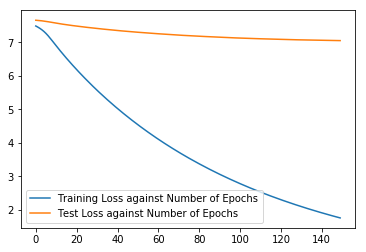

In [56]:
tr_losses
fig2 = plt.figure(figsize=(6,4))
ax1 = fig2.add_subplot(111)
ax1.plot(range(nb_epoch), tr_losses, label="Training Loss against Number of Epochs")
ax1.plot(range(nb_epoch),test_losses,label="Test Loss against Number of Epochs")
ax1.legend(loc=0)
#plt.xlabel("number of epochs")
# plt.ylabel("training loss")
# plt.show()

# Model Analysis

** I thought I was experiencing overfitting, but this does not seem to be the case. To investigate if the model was overfitting, after each epoch I ran a test and recorded both the test loss and training loss for that epoch. I then I plotted them together above. We can see that the test loss is indeed decreasing as the epochs increase but at a very slow rate. For every decrease of the training loss by 0.03/0.04 the test loss decreases approximately by 0.01. The rate of decrease of the training loss is three times as much as the test loss. The way the model is now suggests that for a huge number of epochs the test loss will get low enough, but probably before then overfitting will occur. I do not have the resources
This model did not perform well. I examined another approach to this problem on this dataset but they did not use deep learning. They were able to get an RMSE as low as 0.25. The best RMSE I was able to get was around 1 when I trained for 200 epochs. But I still experience overfitting. This is most likely due to my lack of data. I have much more data available, but my laptop could not handle much more than 10,000 entries. I suspect with more data I would my model would be able to learn more important features. If I also had a more powerful setup I would have carried out hyperparamter grid searh.
Some feature engineering I could have also explored was correcting the data for the meaning rating.**